In [1]:
notebook_id = "210"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [2]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile #notebook

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
#import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot
import s_analysis

#=== network analysis
import networkx as nx
#=== gavity modelling
#import gme as gme

#=== distance datasets
#import wbdata


#### Import module and declare path variables
`import s_filepaths.py`

In [3]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images
path_analysis = s_filepaths.path_analysis

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [4]:
# list of all files
os.listdir(path_live)

# list of file names that can be read with same rule
filename = "125_input_scope_country.csv.gzip"

Load data directly from compressed file to avoid GitHub issues with storage

In [5]:
# Load data
df_network_country = pd.read_csv(f"{path_live}{filename}",compression= "gzip")
df_network_country.head()

year             country_d iso3_d dynamic_code_d  landlocked_d  island_d  \
0  2016  United Arab Emirates    ARE            ARE             0         0   
1  2016               Belgium    BEL            BEL             0         0   
2  2016                 China    CHN            CHN             0         0   
3  2016                 Spain    ESP            ESP             0         0   
4  2016               Georgia    GEO            GEO             0         0   

      region_d  gdp_pwt_const_d  pop_d      lat_d       lng_d country_o  \
0  middle_east              NaN    NaN  25.094378   55.454674  Portugal   
1       europe              NaN    NaN  50.691814    4.581812  Cambodia   
2    east_asia              NaN    NaN  35.389668  114.002470   Belarus   
3       europe              NaN    NaN  39.231297   -4.263840   Belgium   
4       europe              NaN    NaN  42.079079   42.981064      Iran   

  iso3_o dynamic_code_o  landlocked_o  island_o         region_o  pop_o  \
0    PRT            PRT             0         0           europe    NaN   
1    KHM            KHM             0         0  south_east_asia    NaN   
2    BLR            BLR             1         0           europe    NaN   
3    BEL            BEL             0         0           europe    NaN   
4    IRN            IRN             0         0      middle_east    NaN   

       lat_o       lng_o  contiguity   distance  bri_year_d  bri_flag_d  \
0  39.310741  -10.883486           0  6154.4214      2017.0         1.0   
1  12.320902  104.874400           0  9693.0625         NaN         NaN   
2  53.604687   27.802185           0  6904.3364      2013.0         1.0   
3  50.691814    4.581812           0  1374.9351         NaN         NaN   
4  33.925423   52.192562           0  1097.2799      2016.0         1.0   

   economic_distance  institutional_distance  logistics  \
0       32364.307560                0.403792   1.331108   
1       44933.919861                4.775302   1.386359   
2        4153.131454                0.004938   1.492458   
3       11326.515268                1.841935   1.270506   
4        1153.061729                2.290772   1.630717   

   logistics_geo_distance  Import_value  rtCode rt3ISO  ptCode pt3ISO  \
0             8192.201100  2.183510e+08   620.0    PRT   784.0    ARE   
1            13438.064434  3.670375e+08   116.0    KHM    56.0    BEL   
2            10304.432095  4.351889e+08   112.0    BLR   156.0    CHN   
3             1746.863638  7.757618e+09    56.0    BEL   724.0    ESP   
4             1789.352575  8.445334e+07   364.0    IRN   268.0    GEO   

   Export_value  
0  1.794034e+08  
1  3.968047e+08  
2  4.005118e+08  
3  1.049398e+10  
4  7.591084e+07

In [6]:
#df_network_country[df_network_country.country_d == "Azerbaijan"].iloc[0,:].lat_d
#df_network_country[df_network_country.country_d == "Azerbaijan"].iloc[0,:].lng_d

### Prepare data for visualisation

In [7]:
# returns adjancecy matrix [position 0] and list of pairs [1]
array_adjacency = s_adj_matrix_plot.f_adj_matrix(df_network_country,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")

Start-up report | Two different equal count (70) columns are used.


In [8]:
# update formula to dynamically add network characteristics
list_of_distances = ["distance","logistics_geo_distance","institutional_distance","economic_distance"]
#list_of_distances_to_call = ["DD_dummy","DW","DE","DE_minmax","DI","DI_minmax"]

In [9]:
# distance attributes in edges: dw, di, de, di_min_max, de_min_max
list_of_distances_to_call = ["DB","DGW","DGL","DI","DE"]

In [10]:
network_country = s_adj_matrix_plot.f_graph(array_adjacency[1],df_network_country,
                                            p_group_of_countries = list(df_network_country.country_o.unique()),
                                            p_edge_colour="grey",p_colour_group="red",p_seed = 1, 
                                            p_weight = "de_min_max",p_visualise = False,p_edge_traits_columns=list_of_distances,
                                            p_fig_size = (60,60),p_dpi = 150,p_node_size = 500, p_node_font = 30
                                           )

nodes: 70
edges: 139
Message: visualisations turned off.


In [11]:
# create distances
#positions = {k: v for k,v in enumerate(route_shp_load.nodes())}

positions = {}

for node_name in network_country.nodes():
    #print(node_name)
    
    # get coordinates as a tuple
    # filter dataframe
    filter_df = df_network_country[df_network_country.country_d == node_name].iloc[0,:]
    temp_lat = filter_df.lat_d
    temp_lng = filter_df.lng_d
    
    positions.update({node_name : (temp_lng,temp_lat)})

nodes: 70
edges: 139


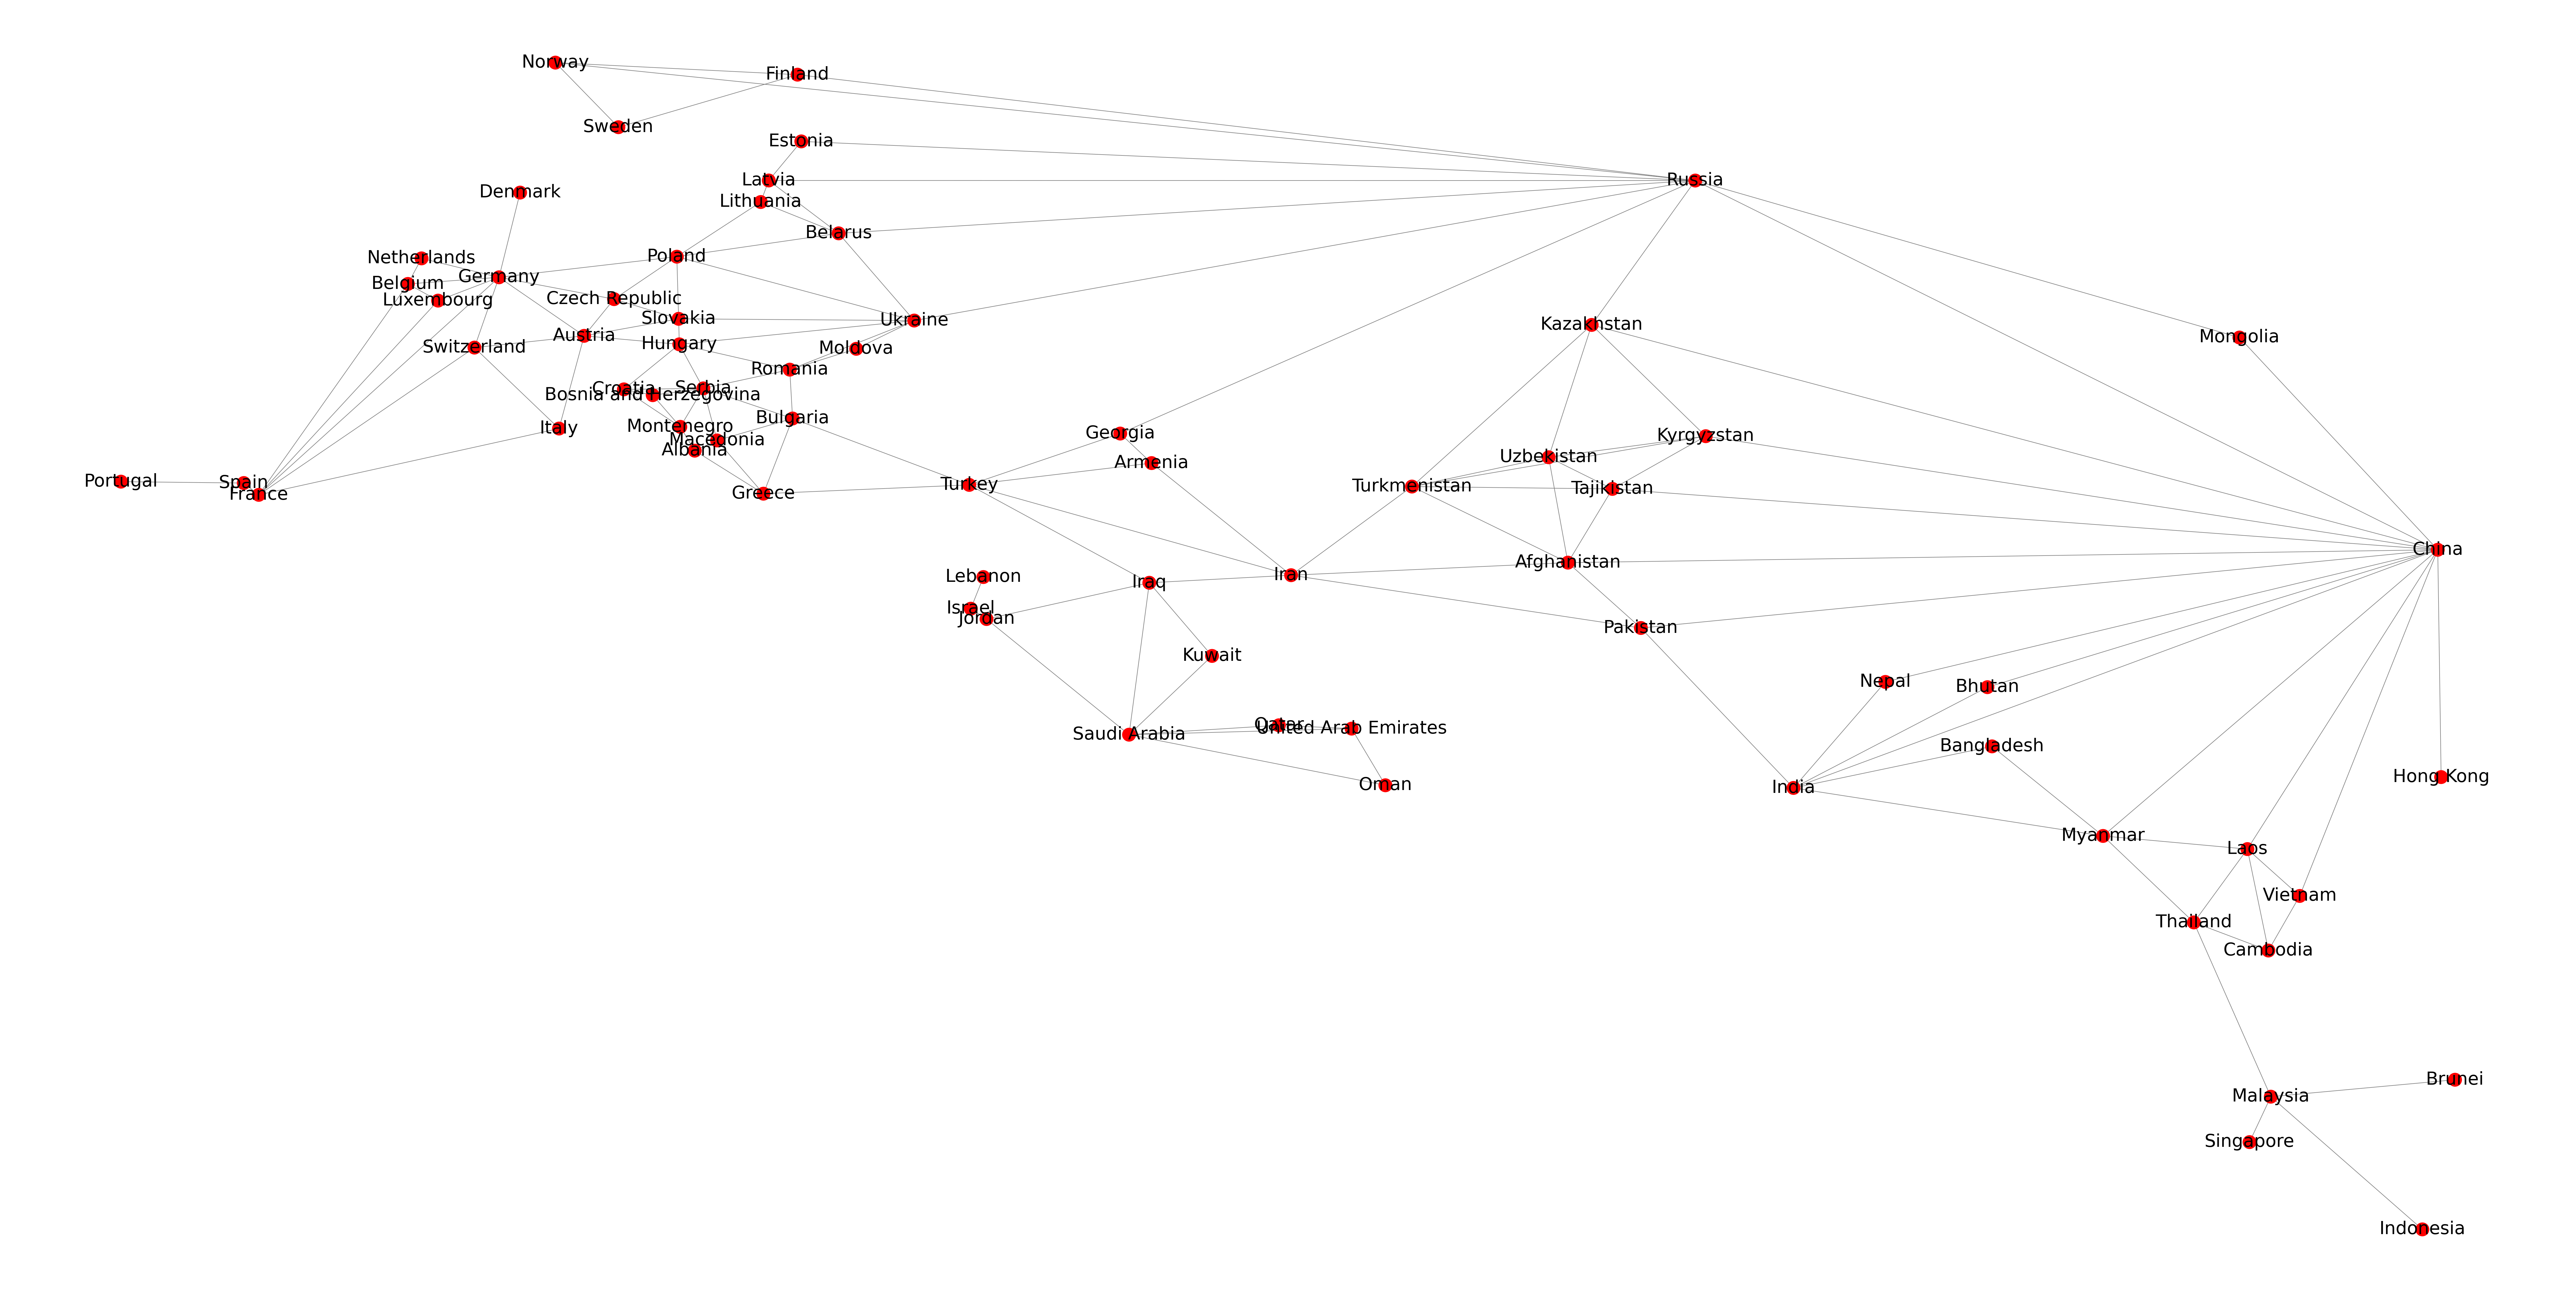

In [12]:
network_country = s_adj_matrix_plot.f_graph(array_adjacency[1],df_network_country,p_group_of_countries = list(df_network_country.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, 
                        p_weight = "de_min_max",p_visualise = True,p_edge_traits_columns=list_of_distances,
                                            p_fig_size = (60,30),p_dpi = 150,p_node_size = 500, p_node_font = 30, p_positions = positions
                                           )

In [13]:
# Code to see all edges and attributes
#nx.get_edge_attributes(network_country,"di_min_max")
#network_country.edges.data()

**Test 1 | Centrality**

In [14]:
# Centrality
centrality = nx.algorithms.centrality.degree_centrality(network_country)

### TEST 1 Measuring network degrees

#### Degree distribution
Code from [here](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html) only amedment done is remaping variables and some stylistic changes.

In [15]:
import collections

In [16]:
outdeg = network_country.degree()
to_highlight = [n[0] for n in outdeg if outdeg[n[0]] >= 7]
normal = [n[0] for n in outdeg if outdeg[n[0]] < 7]

In [17]:
to_highlight

['China', 'Germany', 'Serbia', 'Russia', 'Ukraine']

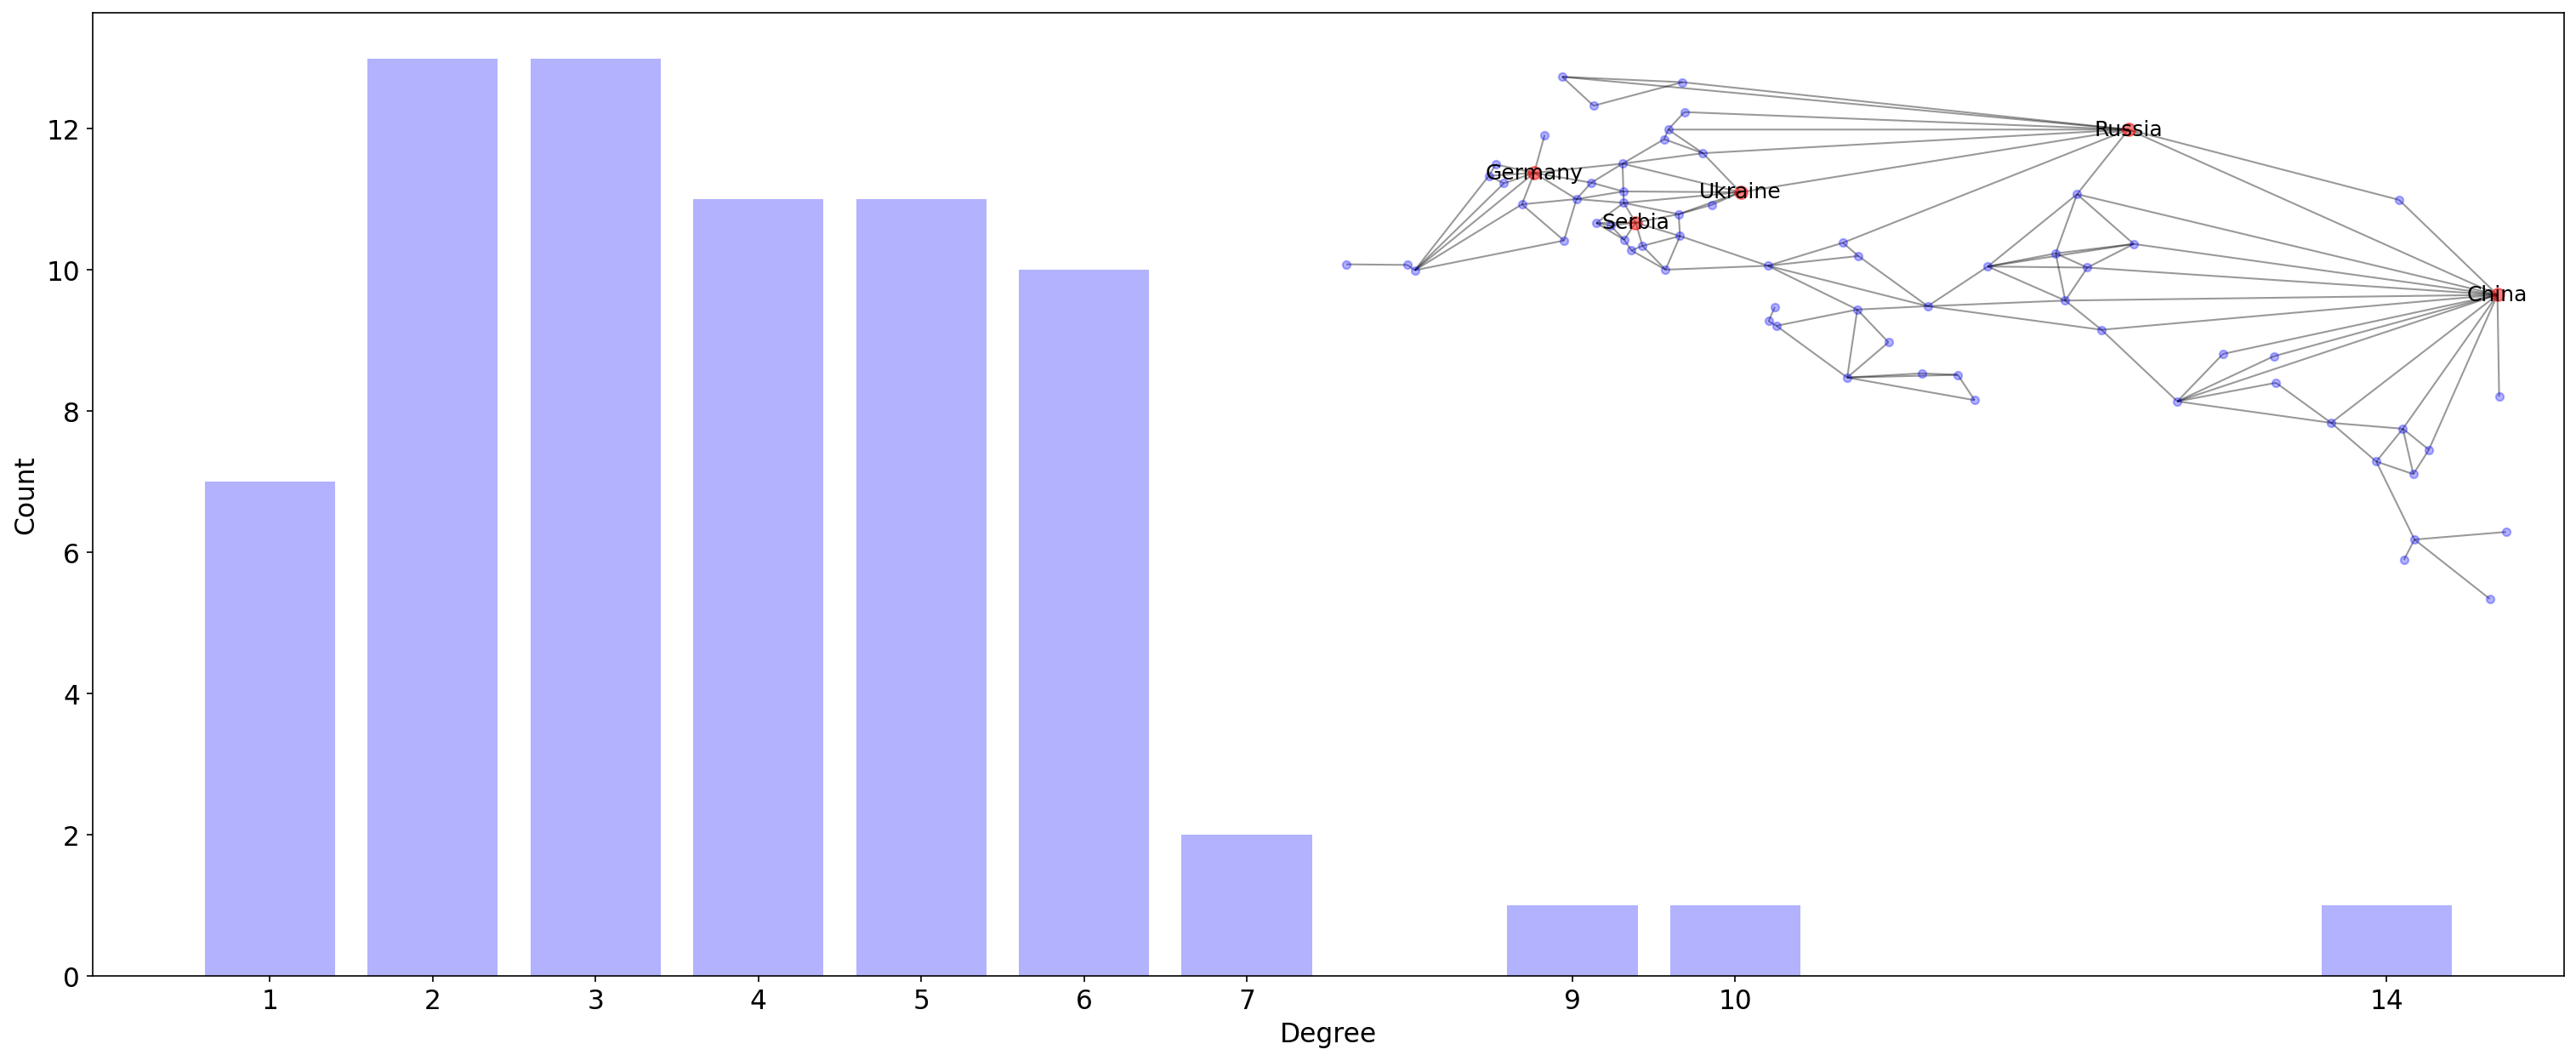

In [18]:
degree_sequence = sorted([d for n, d in network_country.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (25,10),dpi = 150)
plt.bar(deg, cnt, width=0.80, color='b',alpha = 0.3)

#plt.title("Degree Histogram")
plt.ylabel("Count",fontsize = 15)
plt.xlabel("Degree", fontsize = 15)
ax.set_xticks([d + 0 for d in deg])
ax.set_xticklabels(deg,fontsize = 15)
ax.tick_params(axis='y', labelsize= 15) 

# draw graph in inset
plt.axes([0.5, 0.4, 0.4, 0.45])
Gcc = network_country.subgraph(sorted(nx.connected_components(network_country), key=len, reverse=True)[0])
#pos = nx.spring_layout(network_country)
pos = positions
plt.axis('off')
nx.draw_networkx_nodes(to_highlight, pos, node_size=50,node_color = "red",alpha = 0.5,dpi=150)

nx.draw_networkx_labels(network_country, pos=positions,labels = {n:n for index,n in enumerate(to_highlight)})
nx.draw_networkx_nodes(normal, pos, node_size=20,node_color = "blue",alpha = 0.3,dpi=150)
nx.draw_networkx_edges(network_country, pos, alpha=0.4,dpi=150)

plot_name = "country_degree_hist.png"
plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")
plt.show()

### Test 2 | Shortest path test

In [19]:
# Path test
path_start = "China"
path_end = "Germany"

print(list_of_distances_to_call)

['DB', 'DGW', 'DGL', 'DI', 'DE']


In [20]:
list_of_paths = []

for entry in list_of_distances_to_call:
    entry = entry.lower()
    print(f"Shortest path ({entry})| {path_start}=>{path_end} | \n\t{nx.nx.single_source_dijkstra(network_country,path_start,path_end,weight =entry)}")
    print("")
    temp_route = nx.nx.single_source_dijkstra(network_country,path_start,path_end,weight =entry)[1]
    list_of_paths.append(temp_route)

Shortest path (db)| China=>Germany | 
	(4, ['China', 'Russia', 'Belarus', 'Poland', 'Germany'])

Shortest path (dgw)| China=>Germany | 
	(8603.82518, ['China', 'Russia', 'Belarus', 'Poland', 'Germany'])

Shortest path (dgl)| China=>Germany | 
	(12849.643883539522, ['China', 'Russia', 'Belarus', 'Poland', 'Germany'])

Shortest path (di)| China=>Germany | 
	(5.305231582376778, ['China', 'Kazakhstan', 'Russia', 'Ukraine', 'Hungary', 'Austria', 'Germany'])

Shortest path (de)| China=>Germany | 
	(42274.089594089, ['China', 'Kazakhstan', 'Russia', 'Latvia', 'Lithuania', 'Poland', 'Germany'])



Code below takes each shortest path and generates a list of each node and edge per path so that they can be visualised below.

The return is a list of tuples in the format (list of nodes, list of edges) for every path generated above.

In [21]:
# Take lists of paths and create list of nodes and edges to visualise
list_all_edge_lists = []

for index,path_entry in enumerate(list_of_paths):
    
    temp_path_edge_list = []
    
    # cycle through all nodes to create list of edges
    for index,node in enumerate(path_entry[:-1]):
        edge_id = (path_entry[index],path_entry[index+1])
        temp_path_edge_list.append(edge_id)
    
    # use set analysis to take away just generated set of nodes and edges from complete set
    background_nodes = set(network_country.nodes()) - set(path_entry)
    background_edges = set(network_country.edges()) - set(temp_path_edge_list)
    
    list_all_edge_lists.append((path_entry,temp_path_edge_list,background_nodes,background_edges))

**Visualising the routes**
1. Visualising the network in layers:
    - layer of base nodes/edges
    - layer of highlighted nodes/edges that form a given path


**Route 1**

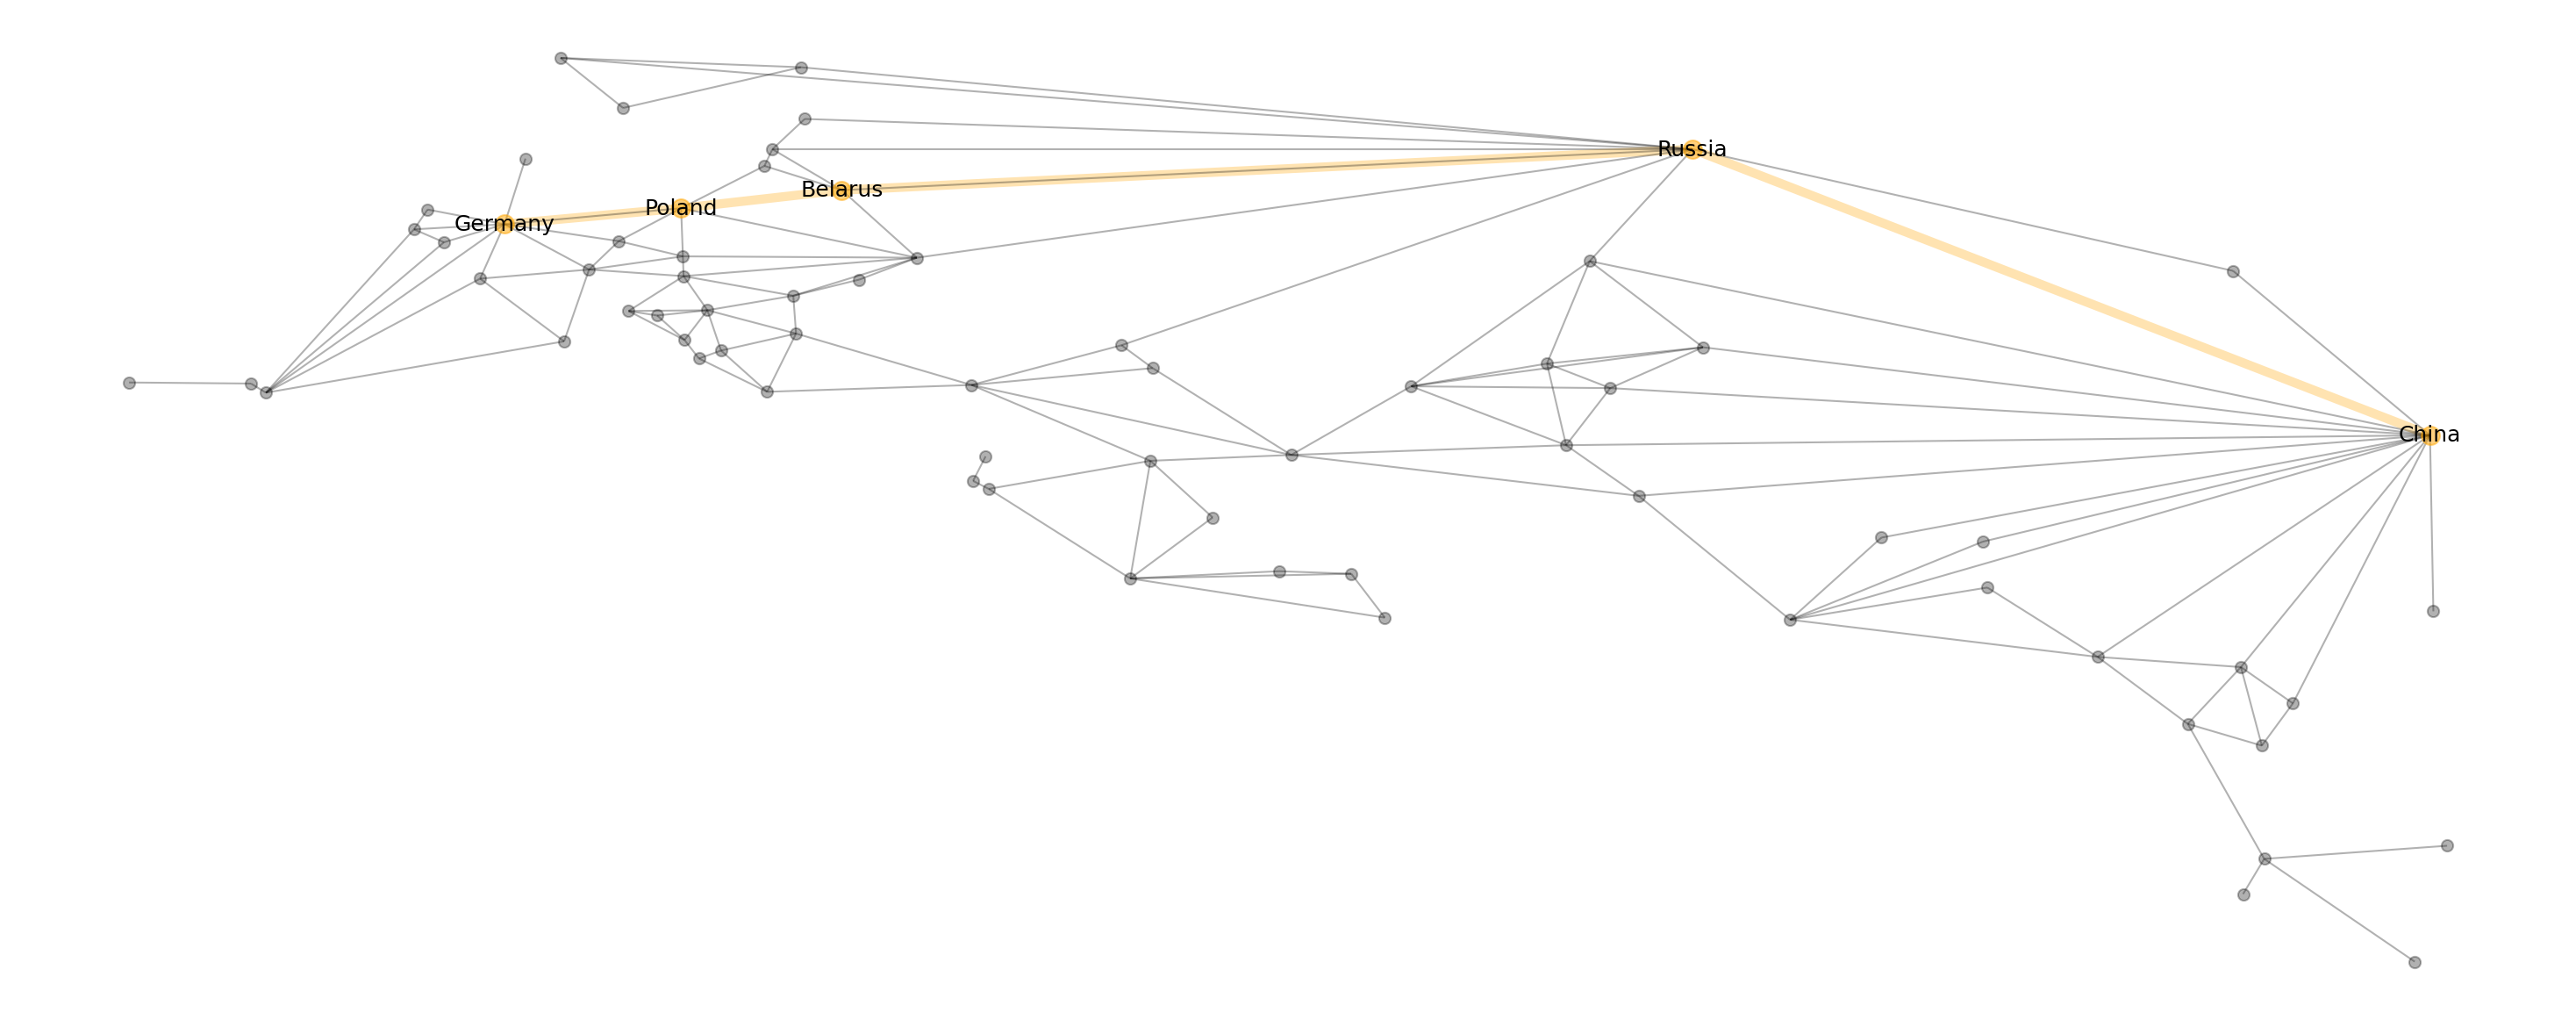

In [22]:
s_analysis.f_210_short_route(list_all_edge_lists[0],network_country,positions,
                  f"{path_image}{notebook_id}_shortest_path_1.png",                  
                  "orange","black")

**Route 2**

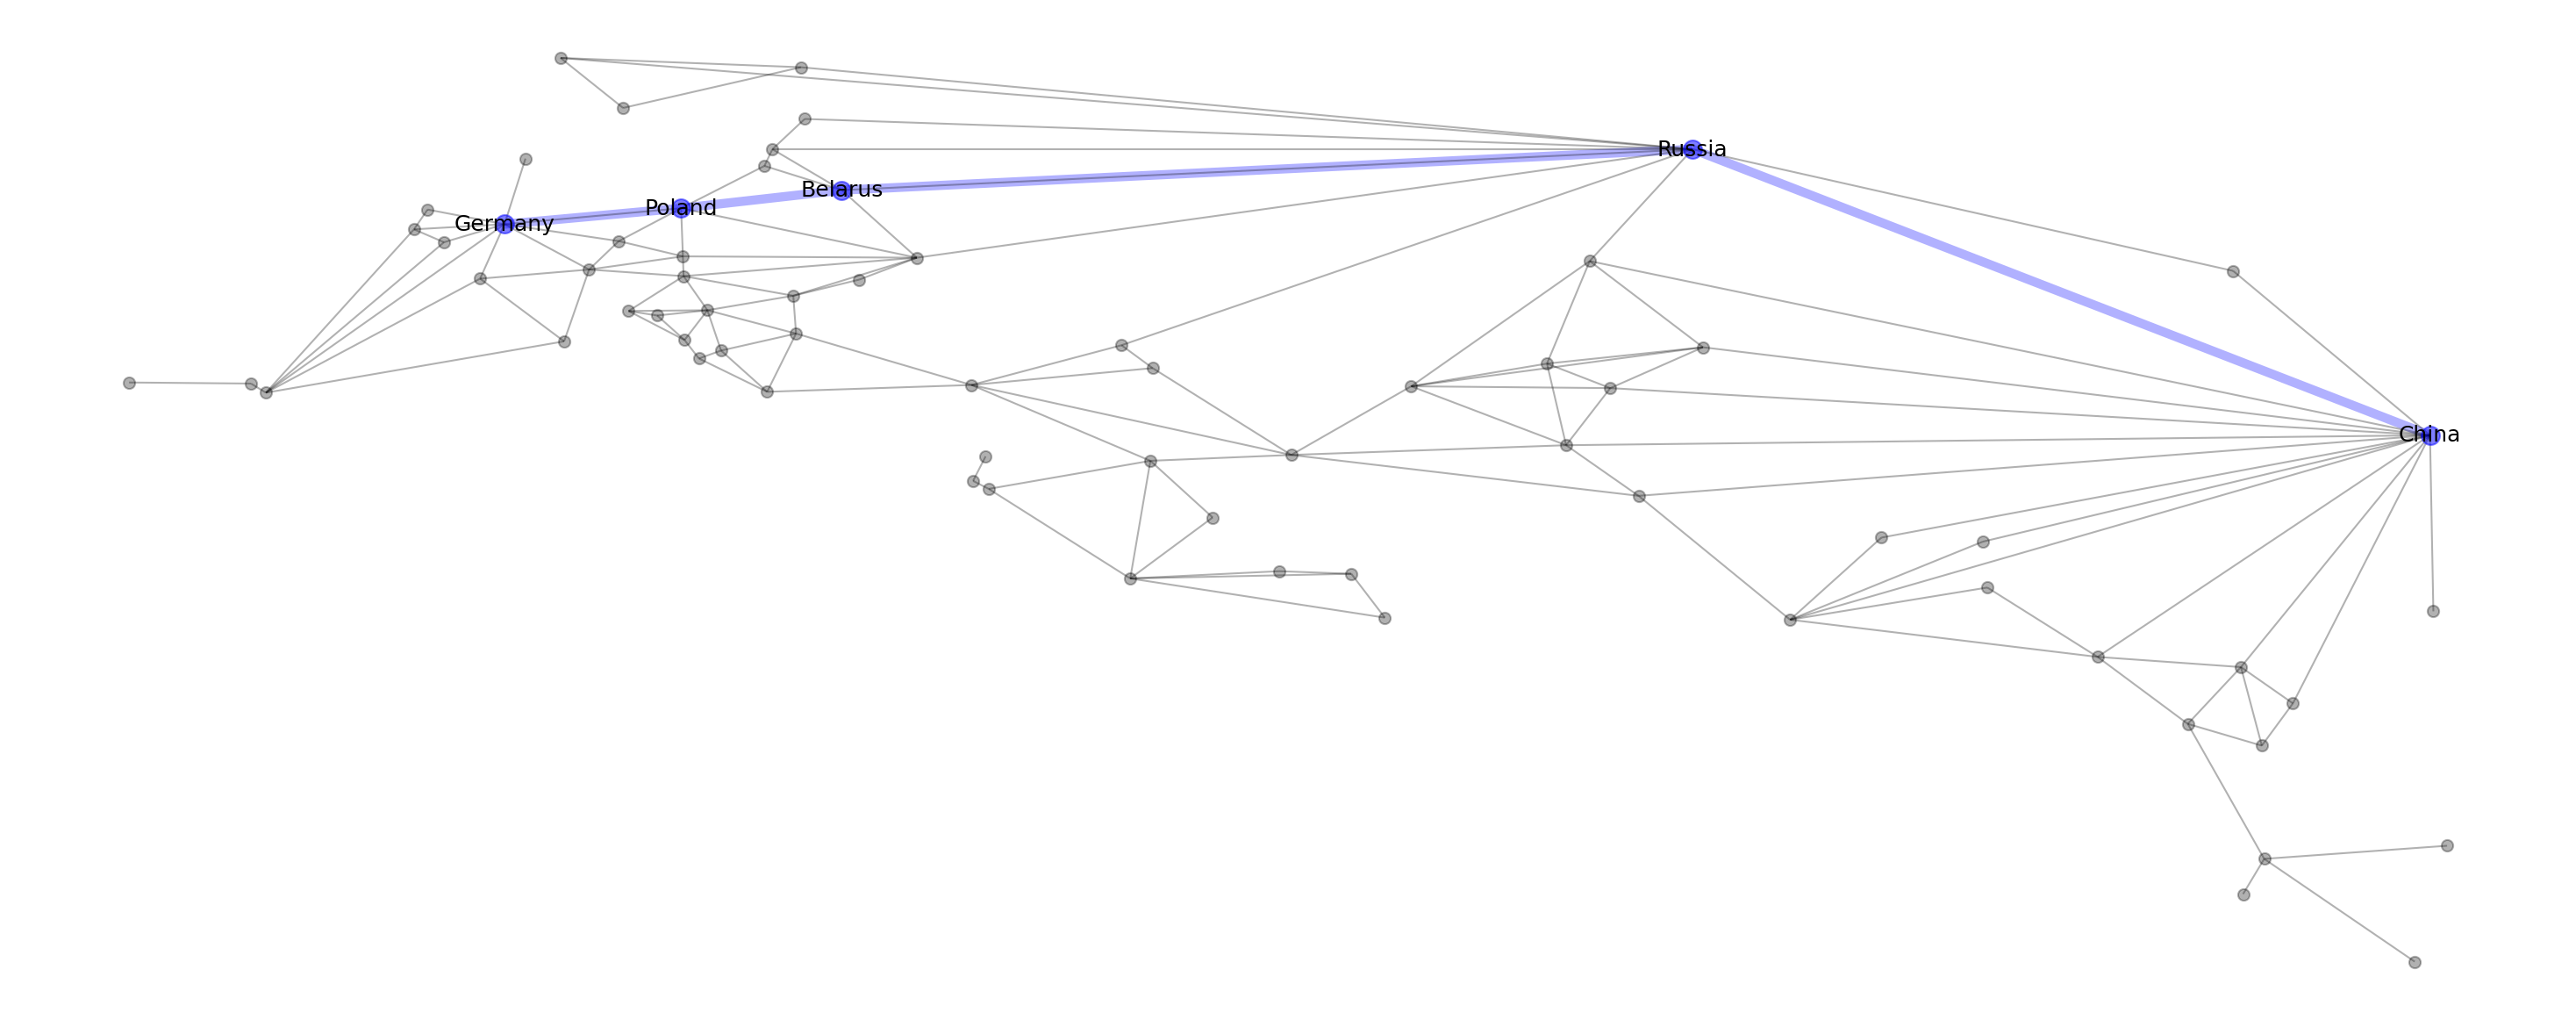

In [23]:
s_analysis.f_210_short_route(list_all_edge_lists[1],network_country,positions,
                  f"{path_image}{notebook_id}_shortest_path_2.png",                  
                  "blue","black")

**Route 3**

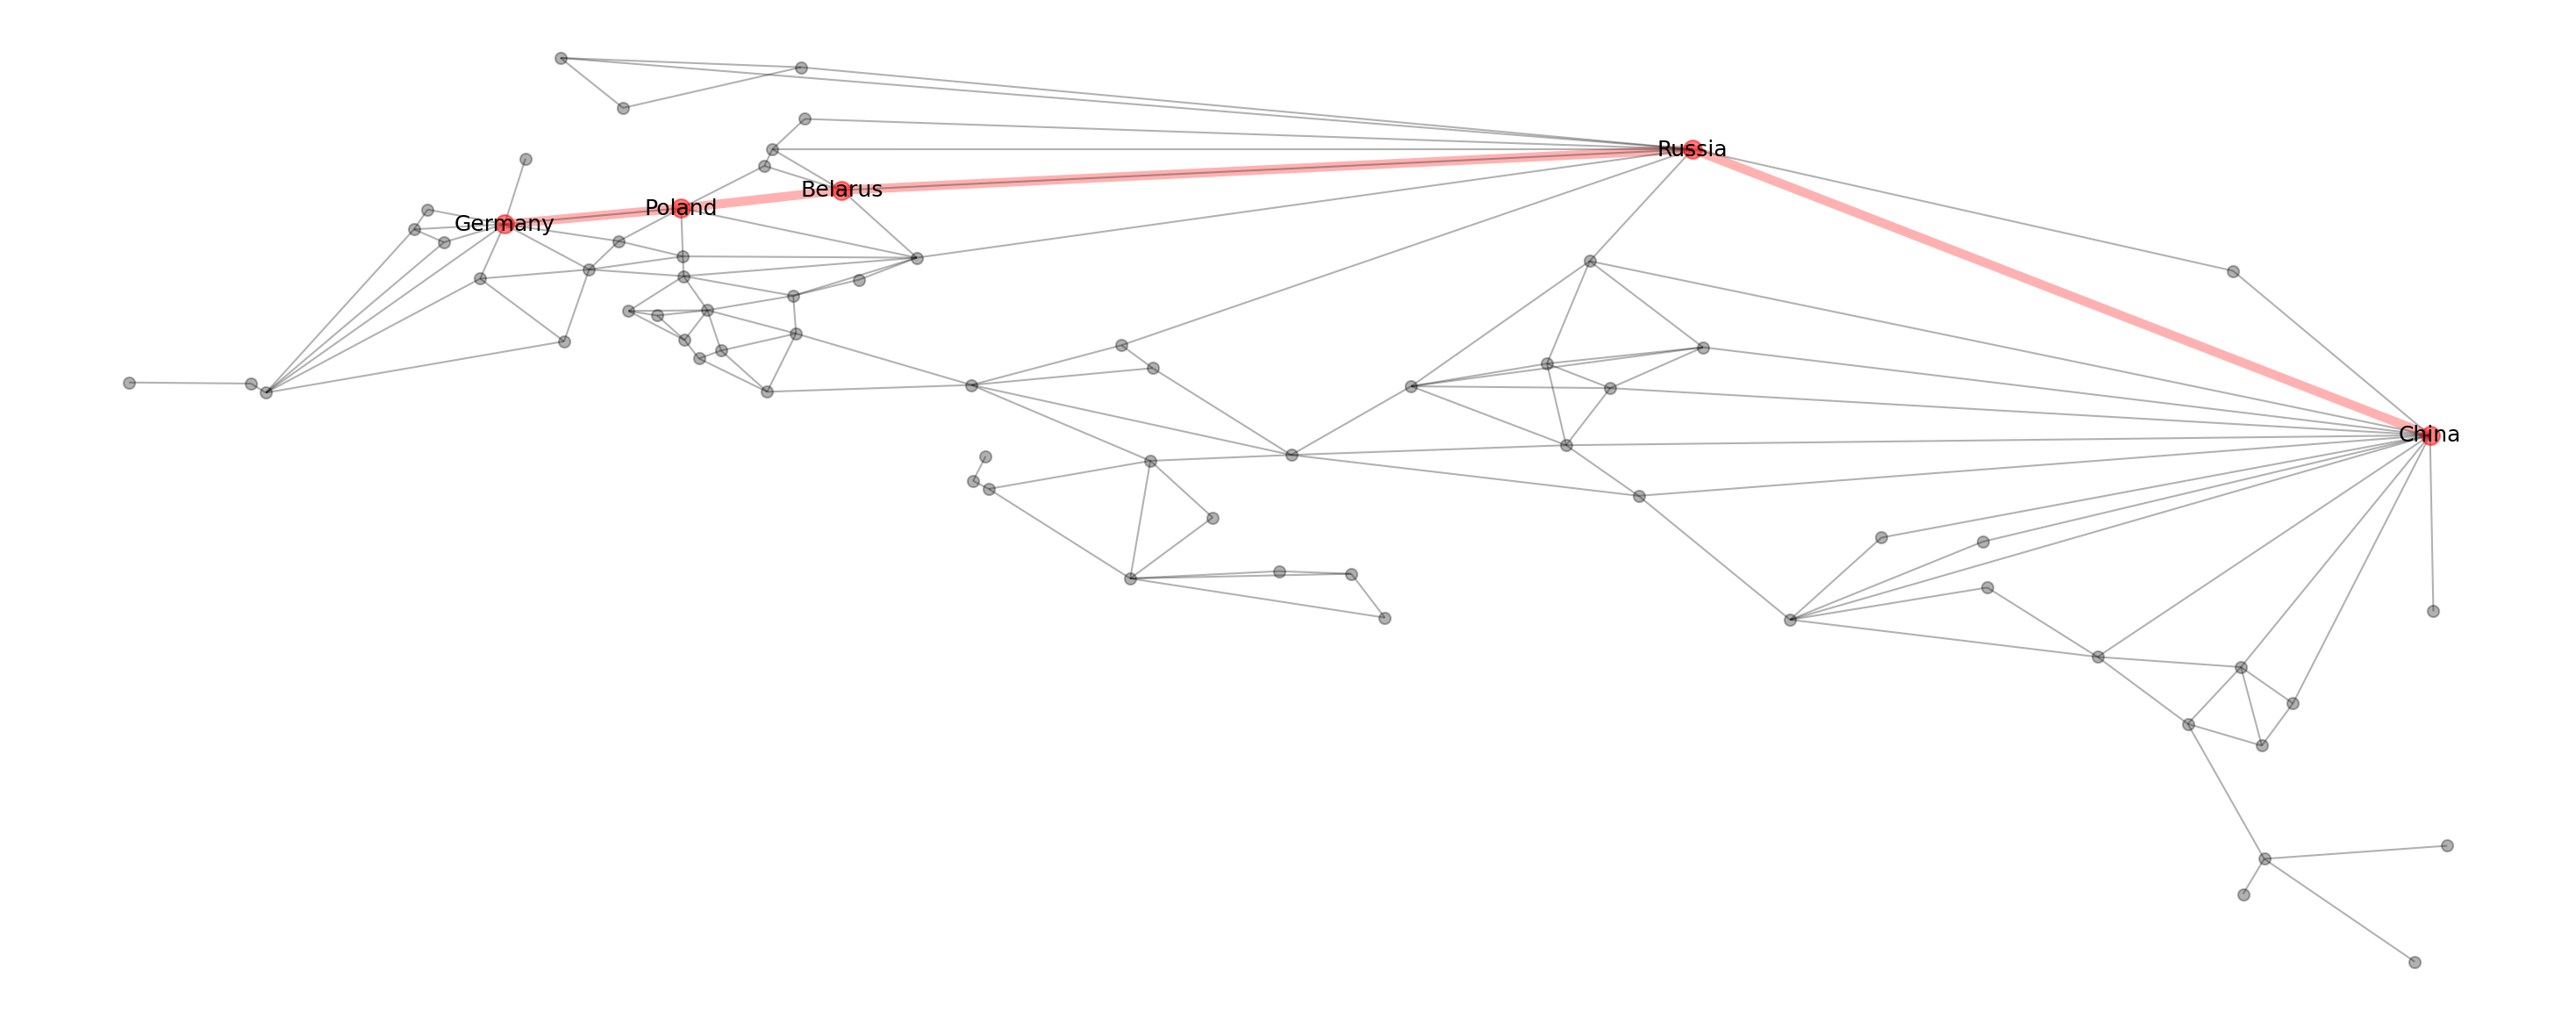

In [24]:
s_analysis.f_210_short_route(list_all_edge_lists[2],network_country,positions,
                  f"{path_image}{notebook_id}_shortest_path_3.png",                  
                  "red","black")

**Route 4**

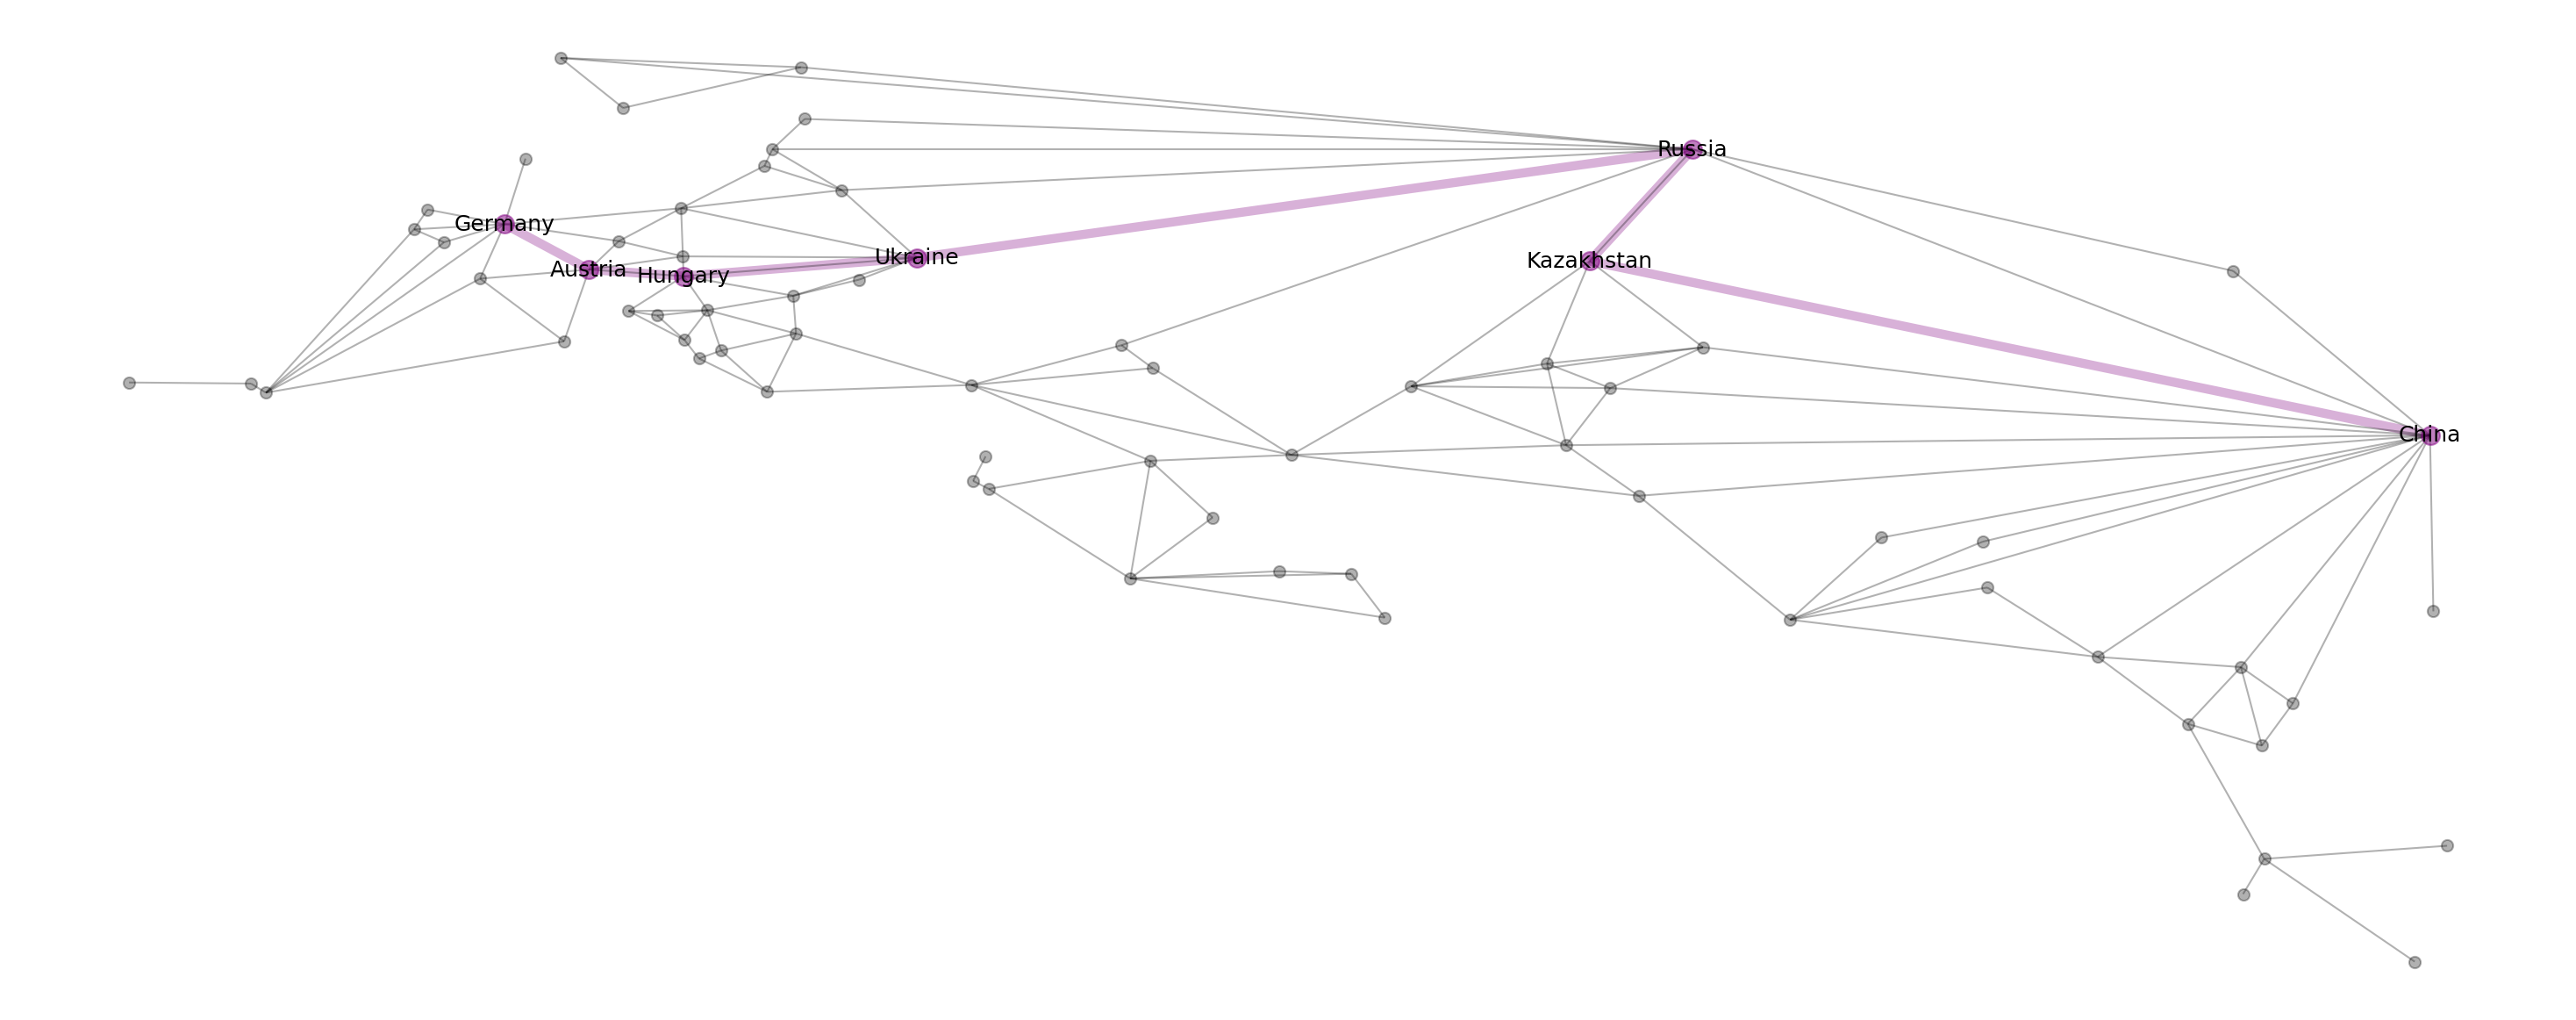

In [25]:
s_analysis.f_210_short_route(list_all_edge_lists[3],network_country,positions,
                  f"{path_image}{notebook_id}_shortest_path_4.png",                  
                  "purple","black")

**Route 5**

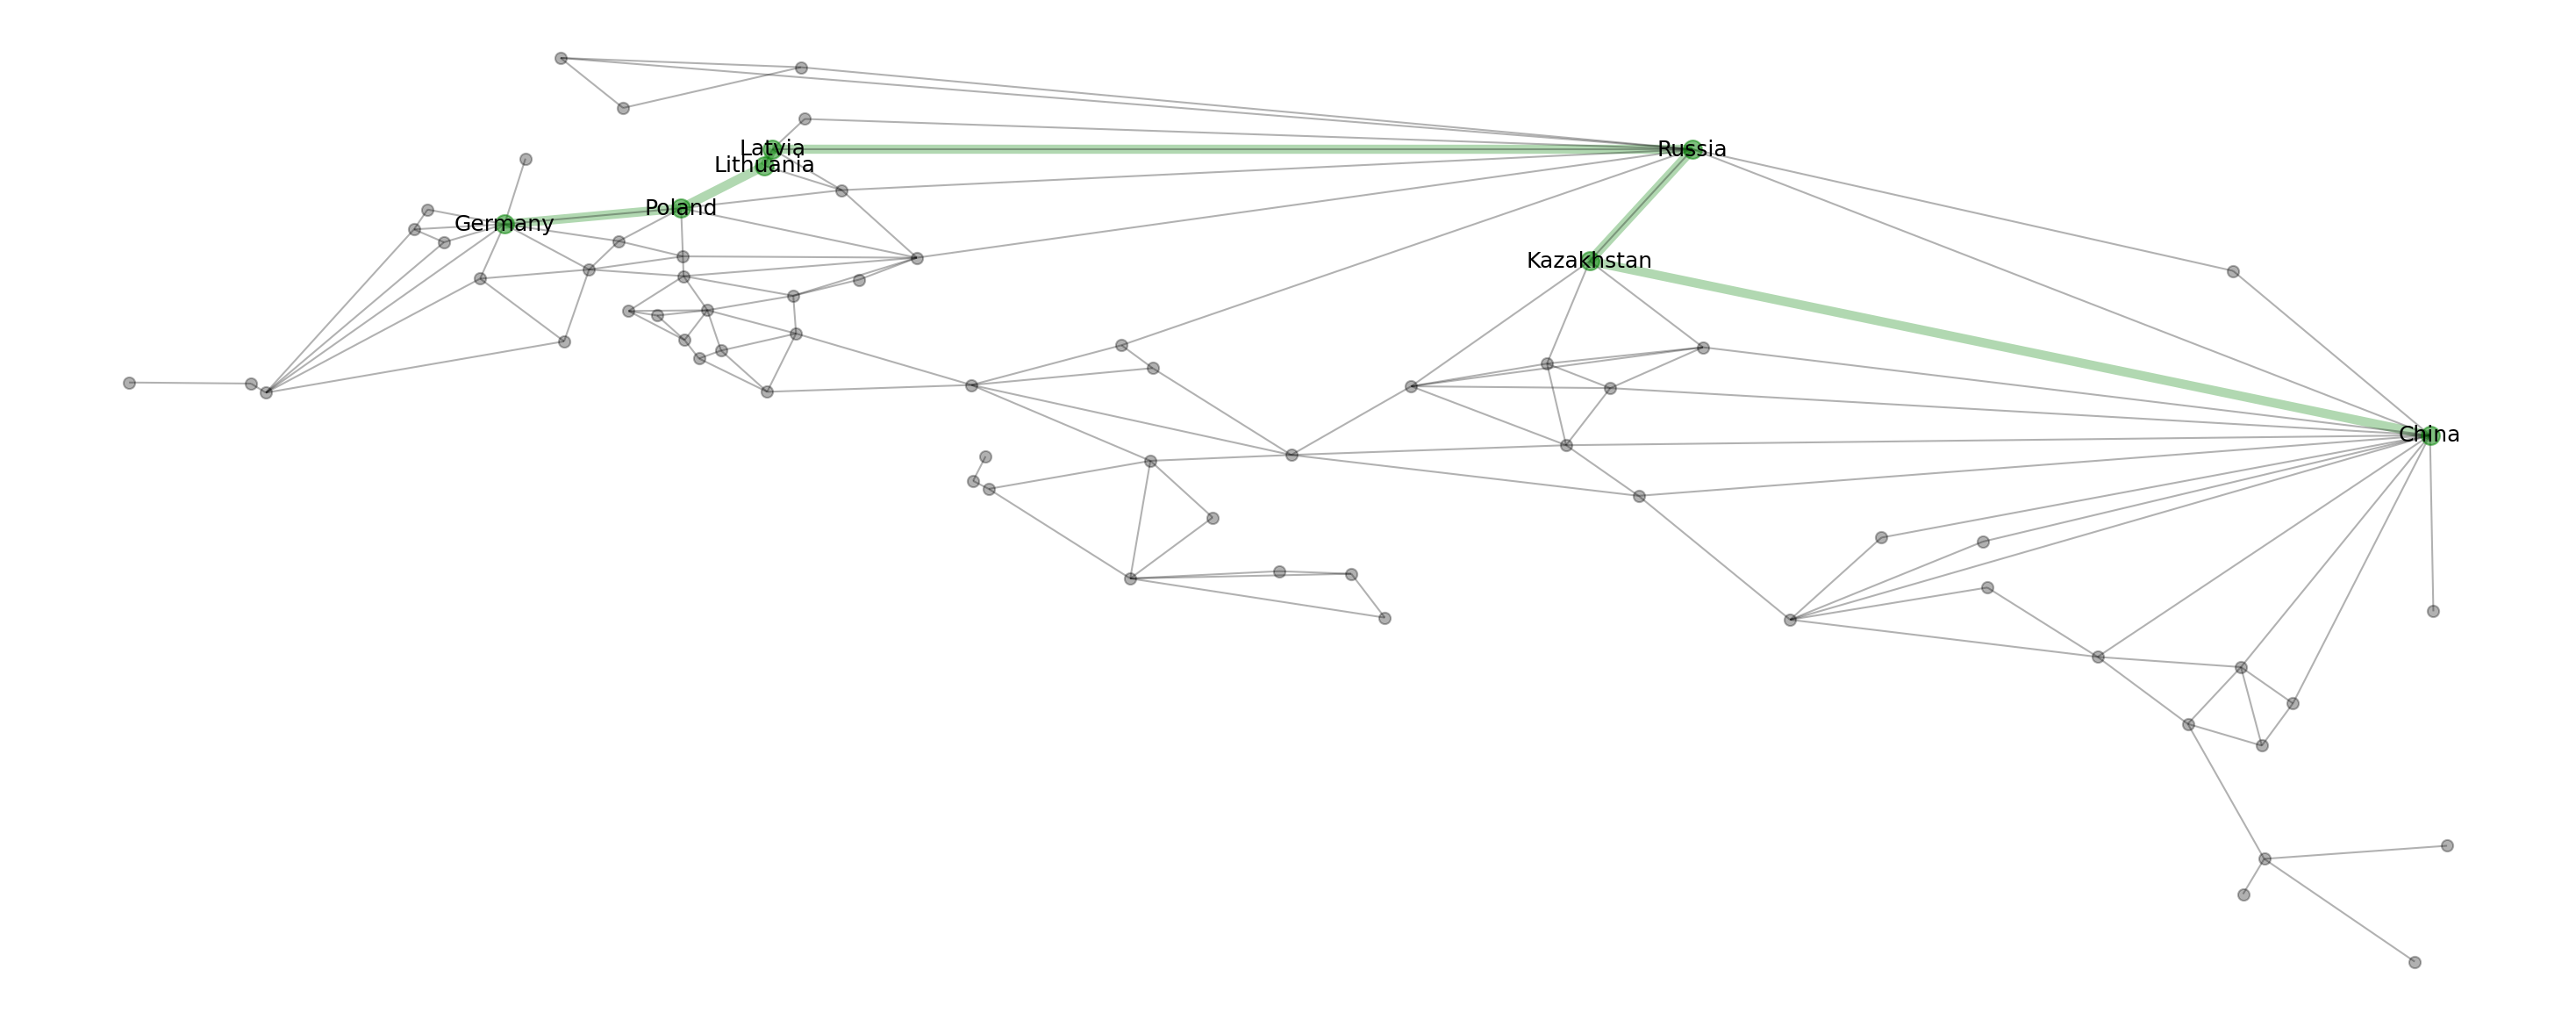

In [26]:
s_analysis.f_210_short_route(list_all_edge_lists[4],network_country,positions,
                  f"{path_image}{notebook_id}_shortest_path_5.png",                  
                  "green","black")

### Test 3 | Betweeness centrality

In [33]:
# betweeness
betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country)

In [34]:
# Assign new names to list
list_of_distances_to_call = ["DB","DGW","DGL","DI","DE"]

# for every distance measure run the test
df_betweeness = pd.DataFrame(index = np.arange(0,len(betweeness_centrality)))

for distance in list_of_distances_to_call:
    
    distance = distance.lower()
    
    print(f"Working on distance: {distance}")
    betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country,weight = distance, k = len(betweeness_centrality))
    temp_df = pd.DataFrame.from_dict(betweeness_centrality,orient = "index",columns=[distance]).reset_index()
    temp_df.columns = [f"Country ({distance})",distance]
    temp_df = temp_df.sort_values(by = distance, ascending = False).reset_index(drop = True).copy()
    
    df_betweeness = df_betweeness.merge(temp_df,how="left",left_index = True,right_index = True).copy()
    
    

Working on distance: db
Working on distance: dgw
Working on distance: dgl
Working on distance: di
Working on distance: de


Examine and describe the resulting dataframe

In [35]:
df_betweeness.head(10)

Country (db)        db Country (dgw)       dgw Country (dgl)       dgl  \
0       Russia  0.430032       Romania  0.403240       Romania  0.404945   
1        China  0.363326      Bulgaria  0.382353        Turkey  0.378090   
2      Ukraine  0.242417        Turkey  0.379795          Iran  0.364024   
3         Iraq  0.208653          Iran  0.365729      Bulgaria  0.355499   
4       Turkey  0.205782       Hungary  0.287298       Hungary  0.318841   
5      Germany  0.178902      Pakistan  0.265132      Pakistan  0.269395   
6       Poland  0.168631         India  0.256607         India  0.249361   
7         Iran  0.140261       Austria  0.211850       Austria  0.209719   
8      Hungary  0.139306          Iraq  0.209292          Iraq  0.209292   
9     Thailand  0.111360       Myanmar  0.172634       Myanmar  0.167093   

  Country (di)        di Country (de)        de  
0       Russia  0.329497       Russia  0.439187  
1      Hungary  0.304025       Poland  0.331770  
2         Iran  0.293532       Latvia  0.331344  
3      Romania  0.288160   Kazakhstan  0.323401  
4        China  0.281374    Lithuania  0.320972  
5     Bulgaria  0.278222         Iran  0.315253  
6      Ukraine  0.261412      Germany  0.245277  
7       Turkey  0.224052        China  0.241901  
8         Iraq  0.208014         Iraq  0.214123  
9      Austria  0.196343     Slovakia  0.192067

In [43]:
df_betweeness.describe().columns

Index(['db', 'dgw', 'dgl', 'di', 'de'], dtype='object')

In [37]:
# Export .csv
bc_filename = "betweeness_centrality"
s_file_export.f_df_export(df_betweeness,bc_filename,p_compression=None,p_loc2=path_analysis,p_loc2_pre="analysis_",p_file_id=f"{notebook_id}_")

No compression
Export | ../Data/1_raw_processed_backup/210_store_betweeness_centrality_20200822_1835.csv | COMPLETE
COPY   | ../Data/3_analysis/210_analysis_betweeness_centrality.csv | COMPLETE


**Visualise results (all)**

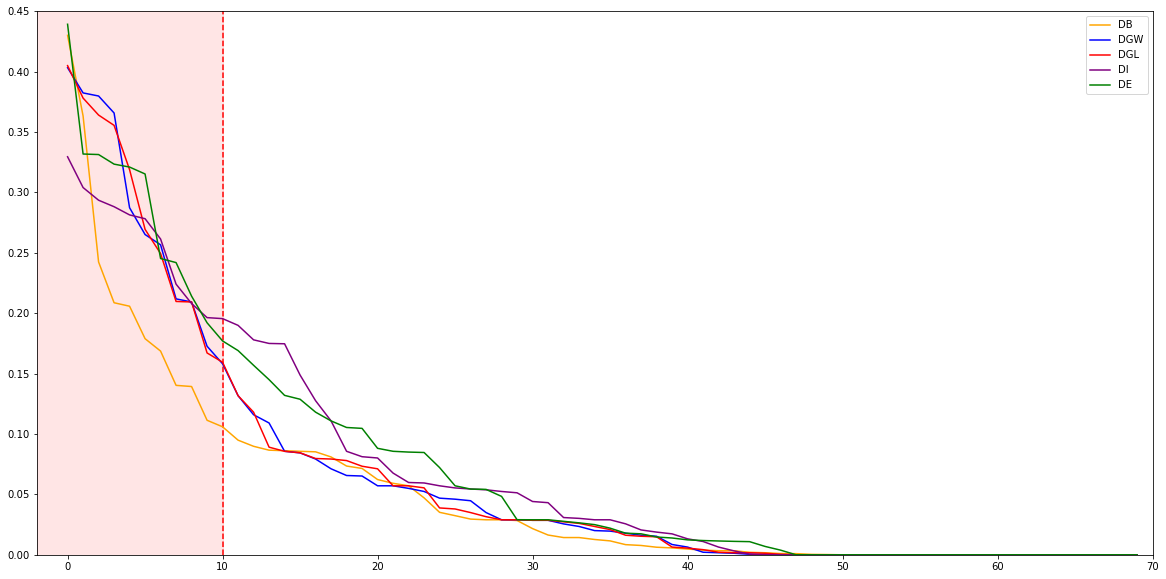

In [77]:
# set up graph
fig,ax = plt.subplots()
plt.xlim(-2,len(df_betweeness))
plt.ylim(0,0.45)

list_of_colours = ["orange","blue","red","purple","green"]

# reference areas
ax.axvspan(-2,10,0,1,color = "r", alpha = 0.1)

# reference horizontal line
#ax.hlines(0.20,-2,10,colors = "r",linestyles = "dashed")

# lines to plot
for index,measure in enumerate(list(df_betweeness.describe().columns)):
    df_betweeness.loc[:,measure].plot(figsize = (20,10), ax = ax, label = measure.upper(), alpha = 1,color = list_of_colours[index])

# vertical reference lines
ax.vlines(10,0,1,colors = "r",linestyles = "dashed")

plt.legend()
plot_name = "betweeness_whole.png"
plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")

**Top 10 results**

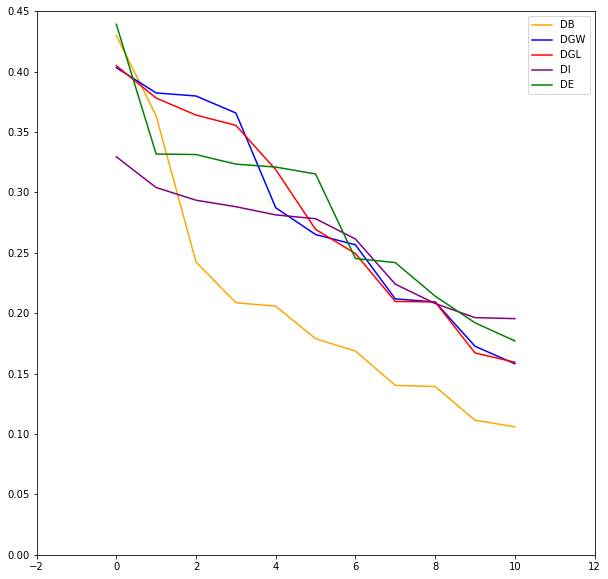

In [110]:
# set up graph
fig,ax = plt.subplots()
plt.xlim(-2,12)
plt.ylim(0,0.45)

list_of_colours = ["orange","blue","red","purple","green"]

# reference areas
#ax.axvspan(-2,10,0,1,color = "r", alpha = 0.1)

# reference horizontal line
#ax.hlines(0.20,-2,10,colors = "r",linestyles = "dashed")

# lines to plot

for index,measure in enumerate(list(df_betweeness.describe().columns)):
    df_betweeness.loc[0:10,measure].plot(figsize = (10,10), ax = ax, label = measure.upper(), alpha = 1,color = list_of_colours[index])

# vertical reference lines
#ax.vlines(10,0,1,colors = "r",linestyles = "dashed")



plt.legend()
plot_name = "betweeness_top_10.png"
plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")

In [131]:
positions["China"]

(114.00247, 35.389668)

In [130]:
test_dict = {n:(positions[n][0],positions[n][1]+10) for n in set(positions)}
test_dict["China"]

(114.00247, 45.389668)

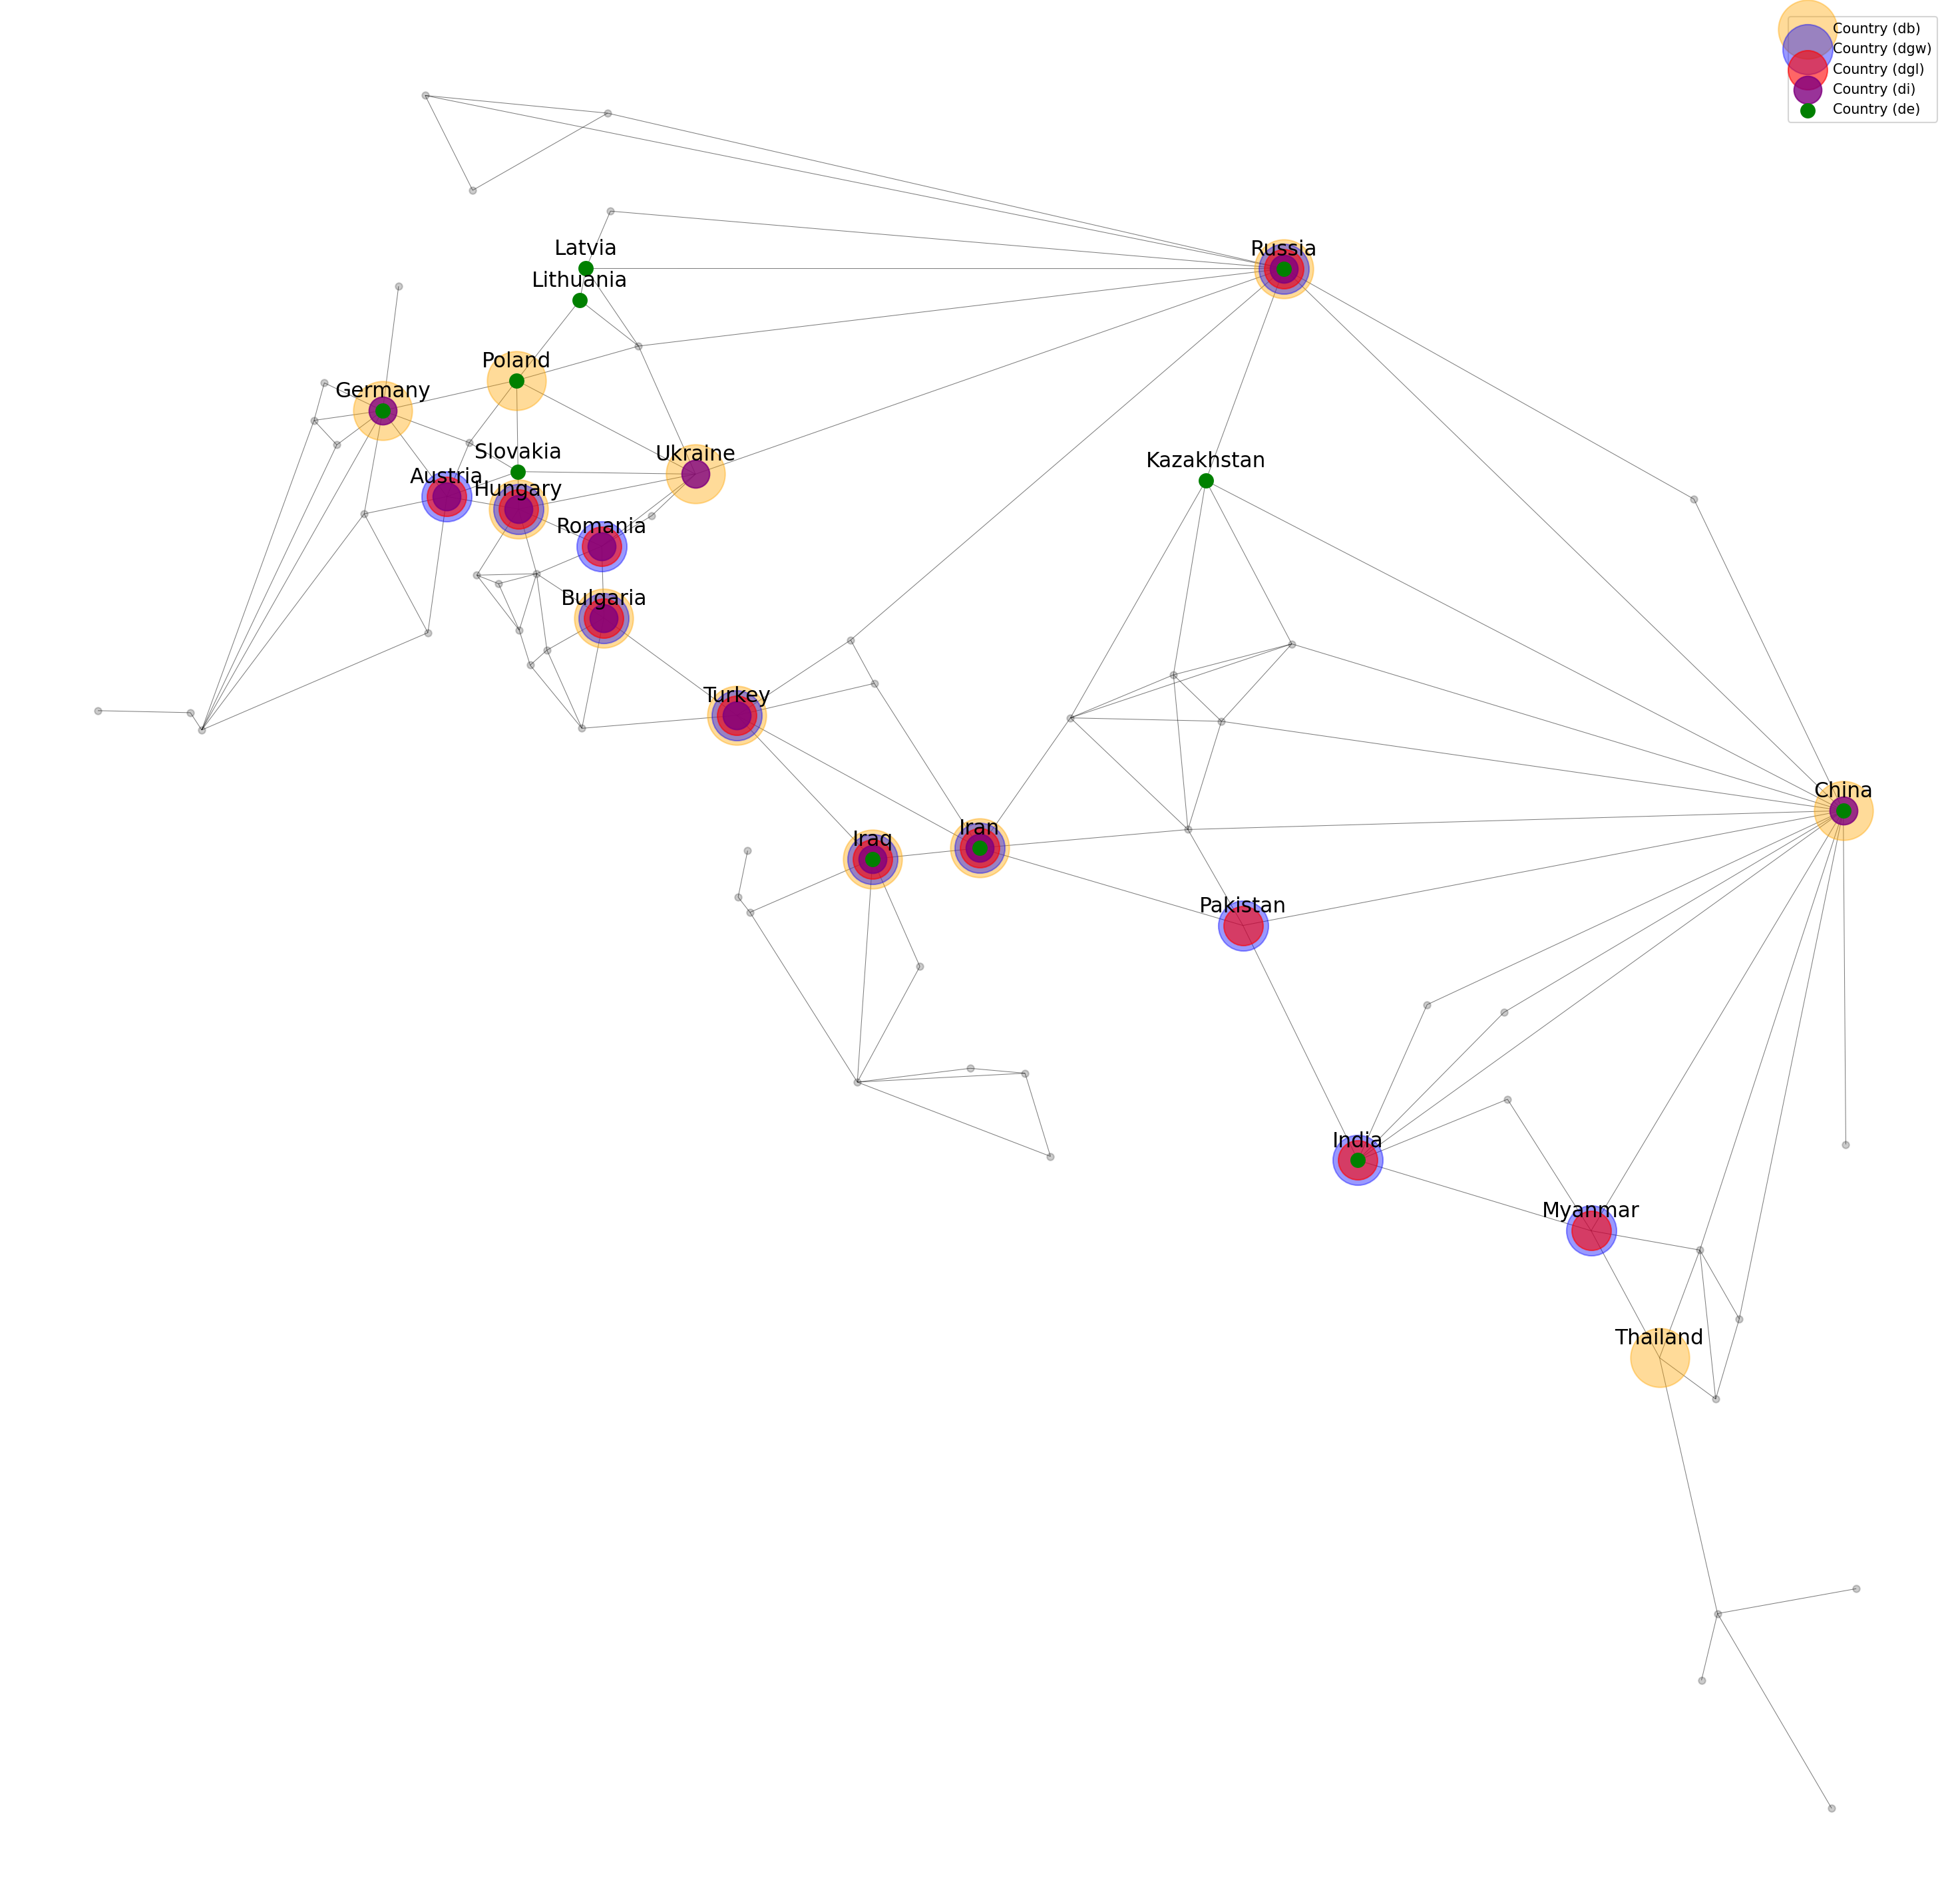

In [144]:
# visualise

fig, ax = plt.subplots(figsize = (25,25),dpi = 150)

ax.tick_params(axis='y', labelsize= 15) 

plt.axis('off')

list_node_size = [1800,1300,800,400,100,100,50]
list_alpha_values = [0.4,0.4,0.6,0.8,1]
highlighted_nodes = []
# nodes to highlight
for index,measure in enumerate(list(df_betweeness.iloc[:,[0,2,4,6,8]].columns)):
    nx.draw_networkx_nodes(df_betweeness.loc[0:10,measure], positions, 
                           node_size=list_node_size[index],node_color = list_of_colours[index],
                           alpha = list_alpha_values[index],dpi=150, label = measure)
    
    highlighted_nodes = highlighted_nodes + list(df_betweeness.loc[0:10,measure])


# add node labels
nx.draw_networkx_labels(network_country,
                        pos = {n:(positions[n][0],positions[n][1]+0.75) for n in set(positions)},
                        labels = {n:n for n in set(highlighted_nodes)},
                        font_color = "k",font_size = 15)
    
# draw remaining nodes
nx.draw_networkx_nodes(set(network_country.nodes())-set(highlighted_nodes),
                       pos = positions,
                       node_size = 25,
                       node_color = "black",alpha = 0.2,dpi=150)



plt.legend()

# draw all edges
nx.draw_networkx_edges(network_country, positions, alpha=0.5,dpi=150,width = 0.5)

plot_name = "betweeness_all.png"
plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")
plt.show()

<a id="ID_part3"></a>
### Part 3 | Placeholder
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||